In [1]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

from scipy import ndimage

from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [2]:
np.random.seed(42)
torch.manual_seed(42)

CUBE_PATH = "../sdss_cube_sfr/SDSS_cube_lean.h5"

In [3]:
with h5py.File(CUBE_PATH, "r") as cube:
    spectra = cube["dense_cube/0/ml_spectrum/spectral_1d_cube_zoom_0"][:]
    images = cube["dense_cube/0/ml_image/cutout_3d_cube_zoom_0"][:]
    metadata = cube["dense_cube/0/ml_spectrum/spec_metadata_refs"][:]

sfrs = pd.read_hdf(CUBE_PATH, key="fits_spectra_metadata_star_formation_rates")
valid_sfrs = sfrs[(sfrs["FLAG"] == 0.0) & (sfrs["Z"].notna())].copy()

In [4]:
metadata_indices = metadata[:, 0]["ds_slice_idx"]
mask = np.in1d(metadata_indices, valid_sfrs.index)

# Загрузка данных для зума 0 для вычисления базовых масок
with h5py.File(CUBE_PATH, "r") as cube:
    spectra_zoom0 = cube["dense_cube/0/ml_spectrum/spectral_1d_cube_zoom_0"][:][mask]
    images_zoom0 = cube["dense_cube/0/ml_image/cutout_3d_cube_zoom_0"][:][mask]

metadata_indices_filtered = metadata_indices[mask]
labels = valid_sfrs.loc[metadata_indices_filtered, "TARGETTYPE"]

In [5]:
def simplify_targettype(val):
    if isinstance(val, bytes):
        val = val.decode("utf-8").strip()
    else:
        val = str(val).strip()
    return "GALAXY" if "GALAXY" in val else "OTHER"

labels_simplified = pd.Series(labels).apply(simplify_targettype).values
galaxy_mask = labels_simplified == "GALAXY"
valid_indices = ~np.isnan(spectra_zoom0).any(axis=1)
final_mask = galaxy_mask & valid_indices
print("Number of objects after filtering:", final_mask.sum())

Number of objects after filtering: 10126


In [6]:
Y_all = valid_sfrs.loc[metadata_indices_filtered, "AVG"].values
Y = Y_all[final_mask]

In [7]:
filters = ["u", "g", "r", "i", "z"]

all_images = []
all_spectra = []

for zoom in range(4):
    img_key = f"dense_cube/{zoom}/ml_image/cutout_3d_cube_zoom_{zoom}"
    spec_key = f"dense_cube/{zoom}/ml_spectrum/spectral_1d_cube_zoom_{zoom}"
    
    with h5py.File(CUBE_PATH, "r") as cube:
        images_zoom = cube[img_key][:][mask]
        spectra_zoom = cube[spec_key][:][mask]
    
    images_zoom = images_zoom[final_mask]
    spectra_zoom = spectra_zoom[final_mask]
    
    if zoom == 0:
        reference_spectrum = spectra_zoom.copy()
        reference_images = images_zoom.copy()
    
    min_val_spec = np.min(reference_spectrum, axis=1, keepdims=True)
    max_val_spec = np.max(reference_spectrum, axis=1, keepdims=True)
    spectra_zoom_normalized = 2 * (spectra_zoom - min_val_spec) / (max_val_spec - min_val_spec) - 1
    
    min_val_img = np.min(reference_images, axis=(2, 3), keepdims=True)
    max_val_img = np.max(reference_images, axis=(2, 3), keepdims=True)
    images_zoom_normalized = 2 * (images_zoom - min_val_img) / (max_val_img - min_val_img) - 1
    
    all_images.append(images_zoom_normalized)
    all_spectra.append(spectra_zoom_normalized)

In [8]:
def detect_and_visualize_multiple_objects(all_images, thresholds, max_objects=20, thumbnail_size=3, crop_sizes=None):
    all_images_trimmed = []
    for i, img_array in enumerate(all_images):
        original_size = img_array.shape[-1]
        target_size = crop_sizes.get(i, original_size)
        
        start = (original_size - target_size) // 2
        end = start + target_size
        
        trimmed = img_array[..., start:end, start:end]
        all_images_trimmed.append(trimmed)
    
    multi_obj_indices = []
    for idx in range(all_images_trimmed[0].shape[0]):
        image = all_images_trimmed[0][idx, 2, :, :]
        image_normalized = (image + 1) / 2
        binary = image_normalized > thresholds[0]
        labeled, num_features = ndimage.label(binary)
        if num_features > 1:
            multi_obj_indices.append(idx)

    if len(multi_obj_indices) > max_objects:
        print(f"Found {len(multi_obj_indices)} objects. Showing first {max_objects}")
        multi_obj_indices = multi_obj_indices[:max_objects]

    if not multi_obj_indices:
        print("No multi-object sources found")
        return all_images_trimmed
    
    num_rows = len(multi_obj_indices)
    fig, axes = plt.subplots(
        num_rows,
        5,
        figsize=(15, thumbnail_size * num_rows),
        dpi=100
    )
    
    if num_rows == 1:
        axes = axes.reshape(1, -1)

    for row, obj_idx in enumerate(multi_obj_indices):
        for col in range(5):
            ax = axes[row, col]
            img_data = all_images_trimmed[0][obj_idx, col, :, :]
            ax.imshow(img_data, vmin=-1, vmax=1)
            ax.set_title(f"Filter {filters[col]}")
            ax.axis("off")

    plt.tight_layout()
    plt.show()
    return all_images_trimmed

In [9]:
THRESHOLDS_4 = {
    0: 0.90,
    1: 0.93,
    2: 0.97,
    3: 0.99
}

CROP_SIZES_4 = {
    0: 32, 
    1: 16, 
    2: 8, 
    3: 4   
}

In [10]:
cropped_images = []
for zoom in range(4):
    img_array = all_images[zoom]
    original_size = img_array.shape[-1]
    target_size = CROP_SIZES_4.get(zoom, original_size)
    start = (original_size - target_size) // 2
    end = start + target_size
    cropped = img_array[..., start:end, start:end]
    cropped_images.append(cropped)

/tmp/ipykernel_406361/2475370851.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


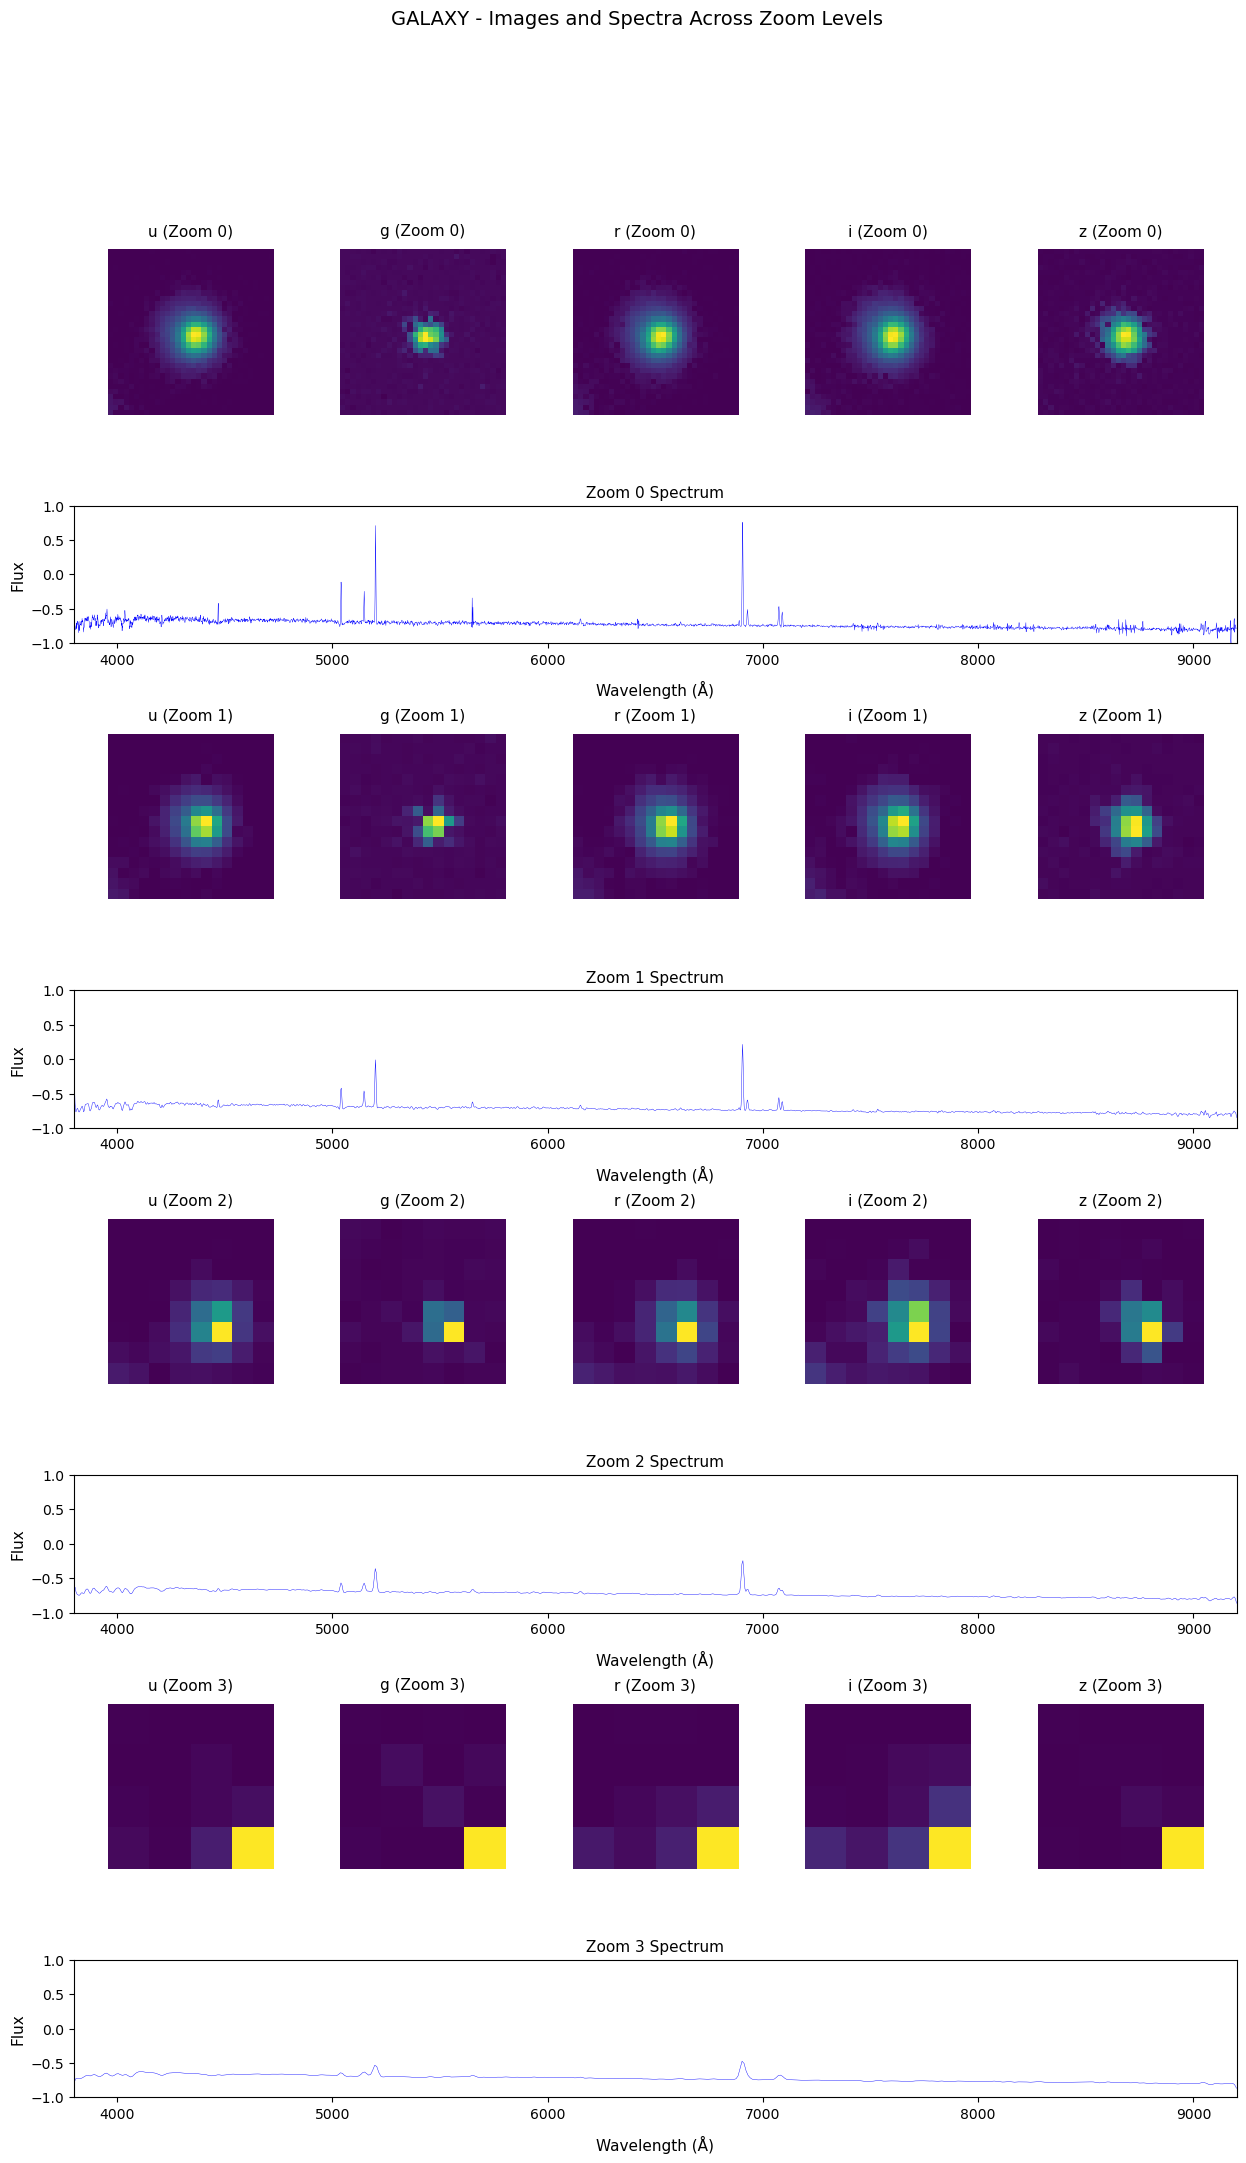

In [11]:
def plot_images_and_spectrum(images, spectra, labels, class_name, obj_num):
    class_index = np.where(labels == class_name)[0]
    if len(class_index) == 0:
        print(f"No images found for class: {class_name}")
        return
    if obj_num >= len(class_index):
        print(f"Object index {obj_num} is out of range. Max available: {len(class_index)-1}")
        return

    idx = class_index[obj_num]
    if len(images) < 4 or len(spectra) < 4:
        print(f"Expected 4 zoom levels, but got {len(images)} images and {len(spectra)} spectra.")
        return

    fig = plt.figure(figsize=(15, 24))
    gs = gridspec.GridSpec(8, 5, height_ratios=[1.2, 1.0, 1.2, 1.0, 1.2, 1.0, 1.2, 1.0], 
                           hspace=0.6, wspace=0.0)

    for zoom in range(4):
        if idx >= len(images[zoom]):
            print(f"Index {idx} is out of bounds for zoom {zoom} images.")
            continue

        img_channels = images[zoom][idx]
        spectrum = spectra[zoom][idx]

        for i in range(5):
            ax = fig.add_subplot(gs[zoom * 2, i])
            ax.imshow(img_channels[i], cmap="viridis")
            ax.set_title(f"{filters[i]} (Zoom {zoom})", fontsize=11, pad=10)
            ax.axis("off")

        ax_spec = fig.add_subplot(gs[zoom * 2 + 1, :])
        zoom_wavelengths = np.linspace(3800, 9200, len(spectrum))
        ax_spec.plot(zoom_wavelengths, spectrum, color="blue", linewidth=0.3)
        ax_spec.set_title(f"Zoom {zoom} Spectrum", fontsize=11)
        ax_spec.set_xlabel("Wavelength (Å)", fontsize=11, labelpad=10)
        ax_spec.set_ylabel("Flux", fontsize=11)
        ax_spec.set_xlim([3800, 9200])
        ax_spec.set_ylim([-1, 1]) 

    fig.suptitle(f"{class_name} - Images and Spectra Across Zoom Levels", fontsize=14)
    plt.tight_layout()
    plt.show()

for i in range(1):
    plot_images_and_spectrum(cropped_images, all_spectra, labels_simplified, "GALAXY", i)

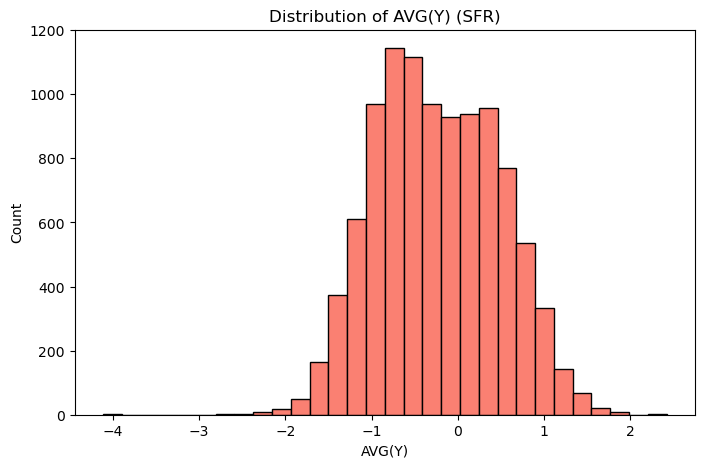

In [12]:

plt.figure(figsize=(8, 5))
plt.hist(Y, bins=30, color='salmon', edgecolor='black')
plt.title("Distribution of AVG(Y) (SFR)")
plt.xlabel("AVG(Y)")
plt.ylabel("Count")
plt.show()


In [13]:
class FusionNet(nn.Module):
    def __init__(self, img_input_dim, spec_input_dim):
        super(FusionNet, self).__init__()
        self.img_branch = nn.Sequential(
            nn.Linear(img_input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU()
        )
        self.spec_branch = nn.Sequential(
            nn.Linear(spec_input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU()
        )
        self.fusion = nn.Sequential(
            nn.Linear(32 + 32, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
    def forward(self, x_img, x_spec):
        img_feat = self.img_branch(x_img)
        spec_feat = self.spec_branch(x_spec)
        combined = torch.cat([img_feat, spec_feat], dim=1)
        out = self.fusion(combined)
        return out

class EarlyFusionNet(nn.Module):
    def __init__(self, combined_input_dim):
        super(EarlyFusionNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(combined_input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        return self.net(x)

# BranchNet for Late Fusion (trained separately)
class BranchNet(nn.Module):
    def __init__(self, input_dim):
        super(BranchNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
    def forward(self, x):
        return self.net(x)

In [14]:
def train_two_branch_model(model, train_loader, val_loader, num_epochs=100, lr=1e-3):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    best_epoch = -1
    best_state = None
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for batch_img, batch_spec, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_img, batch_spec)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * batch_y.size(0)
        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for batch_img, batch_spec, batch_y in val_loader:
                outputs = model(batch_img, batch_spec)
                loss = criterion(outputs, batch_y)
                running_val_loss += loss.item() * batch_y.size(0)
        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)
        print(f"Epoch {epoch+1}: Train Loss {epoch_train_loss:.4f} / Val Loss {epoch_val_loss:.4f}")
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            best_epoch = epoch
            best_state = model.state_dict()
    model.load_state_dict(best_state)
    return model, train_losses, val_losses, best_epoch

In [15]:
def train_single_input_model(model, train_loader, val_loader, num_epochs=100, lr=1e-3):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    best_epoch = -1
    best_state = None
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * batch_y.size(0)
        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                outputs = model(batch_x)
                loss = criterion(outputs, batch_y)
                running_val_loss += loss.item() * batch_y.size(0)
        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)
        print(f"Epoch {epoch+1}: Train Loss {epoch_train_loss:.4f} / Val Loss {epoch_val_loss:.4f}")
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            best_epoch = epoch
            best_state = model.state_dict()
    model.load_state_dict(best_state)
    return model, train_losses, val_losses, best_epoch

In [16]:
# Dictionary to store results for each spectra zoom level
results_fusion = {}

# Use the fixed image modality from cropped_images[0]
X_img = cropped_images[0]
n_samples = X_img.shape[0]
X_img = X_img.reshape(n_samples, -1)  # flatten images

results_fusion = {}
results_early = {}
results_late = {}

In [17]:
for spec_zoom in range(4):
    print(f"\n--- Spectra Zoom {spec_zoom} ---")
    # Process spectra for current zoom level
    X_spec = all_spectra[spec_zoom]
    if len(X_spec.shape) > 2:
        X_spec = X_spec.reshape(n_samples, -1)
    
    # Impute any missing values in spectra before scaling
    imputer = SimpleImputer(strategy='mean')
    X_spec = imputer.fit_transform(X_spec)
    
    # Scale and apply PCA for image and spectra modalities separately
    scaler_img = StandardScaler()
    scaler_spec = StandardScaler()
    X_img_scaled = scaler_img.fit_transform(X_img)
    X_spec_scaled = scaler_spec.fit_transform(X_spec)
    
    n_components_img = 100
    n_components_spec = 100
    pca_img = PCA(n_components=n_components_img)
    pca_spec = PCA(n_components=n_components_spec)
    X_img_pca = pca_img.fit_transform(X_img_scaled)
    X_spec_pca = pca_spec.fit_transform(X_spec_scaled)
    
    # -----------------------
    # FusionNet (Intermediate Fusion)
    # -----------------------
    X_img_train, X_img_temp, X_spec_train, X_spec_temp, y_train, y_temp = train_test_split(
        X_img_pca, X_spec_pca, Y, test_size=0.4, random_state=42)
    X_img_val, X_img_test, X_spec_val, X_spec_test, y_val, y_test = train_test_split(
        X_img_temp, X_spec_temp, y_temp, test_size=0.5, random_state=42)
    
    X_img_train_tensor = torch.tensor(X_img_train, dtype=torch.float32)
    X_spec_train_tensor = torch.tensor(X_spec_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
    X_img_val_tensor = torch.tensor(X_img_val, dtype=torch.float32)
    X_spec_val_tensor = torch.tensor(X_spec_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
    
    train_dataset_fusion = TensorDataset(X_img_train_tensor, X_spec_train_tensor, y_train_tensor)
    val_dataset_fusion = TensorDataset(X_img_val_tensor, X_spec_val_tensor, y_val_tensor)
    batch_size = 64
    train_loader_fusion = DataLoader(train_dataset_fusion, batch_size=batch_size, shuffle=True)
    val_loader_fusion = DataLoader(val_dataset_fusion, batch_size=batch_size, shuffle=False)
    
    model_fusion = FusionNet(n_components_img, n_components_spec)
    print("Training FusionNet...")
    model_fusion, fusion_train_losses, fusion_val_losses, fusion_best_epoch = train_two_branch_model(
        model_fusion, train_loader_fusion, val_loader_fusion, num_epochs=100, lr=1e-3)
    
    X_img_test_tensor = torch.tensor(X_img_test, dtype=torch.float32)
    X_spec_test_tensor = torch.tensor(X_spec_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)
    test_dataset_fusion = TensorDataset(X_img_test_tensor, X_spec_test_tensor, y_test_tensor)
    test_loader_fusion = DataLoader(test_dataset_fusion, batch_size=batch_size, shuffle=False)
    
    model_fusion.eval()
    fusion_preds = []
    with torch.no_grad():
        for batch_img, batch_spec, batch_y in test_loader_fusion:
            outputs = model_fusion(batch_img, batch_spec)
            fusion_preds.append(outputs.cpu().numpy())
    fusion_preds = np.vstack(fusion_preds)
    mse_fusion = mean_squared_error(y_test, fusion_preds)
    r2_fusion = r2_score(y_test, fusion_preds)
    results_fusion[spec_zoom] = {'Test MSE': mse_fusion, 'R2': r2_fusion}
    print(f"FusionNet (Spectra Zoom {spec_zoom}) - Test MSE: {mse_fusion:.4f}, R2: {r2_fusion:.4f}")
    
    # -----------------------
    # EarlyFusionNet (Early Fusion)
    # -----------------------
    X_early = np.concatenate([X_img_pca, X_spec_pca], axis=1)
    X_early_train, X_early_temp, y_train_early, y_temp_early = train_test_split(
        X_early, Y, test_size=0.4, random_state=42)
    X_early_val, X_early_test, y_val_early, y_test_early = train_test_split(
        X_early_temp, y_temp_early, test_size=0.5, random_state=42)
    
    X_early_train_tensor = torch.tensor(X_early_train, dtype=torch.float32)
    y_train_early_tensor = torch.tensor(y_train_early, dtype=torch.float32).unsqueeze(1)
    X_early_val_tensor = torch.tensor(X_early_val, dtype=torch.float32)
    y_val_early_tensor = torch.tensor(y_val_early, dtype=torch.float32).unsqueeze(1)
    
    train_dataset_early = TensorDataset(X_early_train_tensor, y_train_early_tensor)
    val_dataset_early = TensorDataset(X_early_val_tensor, y_val_early_tensor)
    train_loader_early = DataLoader(train_dataset_early, batch_size=batch_size, shuffle=True)
    val_loader_early = DataLoader(val_dataset_early, batch_size=batch_size, shuffle=False)
    
    combined_input_dim = n_components_img + n_components_spec
    model_early = EarlyFusionNet(combined_input_dim)
    print("Training EarlyFusionNet...")
    model_early, early_train_losses, early_val_losses, early_best_epoch = train_single_input_model(
        model_early, train_loader_early, val_loader_early, num_epochs=100, lr=1e-3)
    
    X_early_test_tensor = torch.tensor(X_early_test, dtype=torch.float32)
    y_test_early_tensor = torch.tensor(y_test_early, dtype=torch.float32).unsqueeze(1)
    test_dataset_early = TensorDataset(X_early_test_tensor, y_test_early_tensor)
    test_loader_early = DataLoader(test_dataset_early, batch_size=batch_size, shuffle=False)
    
    model_early.eval()
    early_preds = []
    with torch.no_grad():
        for batch_x, batch_y in test_loader_early:
            outputs = model_early(batch_x)
            early_preds.append(outputs.cpu().numpy())
    early_preds = np.vstack(early_preds)
    mse_early = mean_squared_error(y_test_early, early_preds)
    r2_early = r2_score(y_test_early, early_preds)
    results_early[spec_zoom] = {'Test MSE': mse_early, 'R2': r2_early}
    print(f"EarlyFusionNet (Spectra Zoom {spec_zoom}) - Test MSE: {mse_early:.4f}, R2: {r2_early:.4f}")
    
    # -----------------------
    # Late Fusion: Train separate BranchNet models for images and spectra and average predictions
    # -----------------------
    # Train image branch
    X_img_train_late, X_img_temp_late, y_train_late, y_temp_late = train_test_split(
        X_img_pca, Y, test_size=0.4, random_state=42)
    X_img_val_late, X_img_test_late, y_val_late, y_test_late = train_test_split(
        X_img_temp_late, y_temp_late, test_size=0.5, random_state=42)
    X_img_train_tensor = torch.tensor(X_img_train_late, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_late, dtype=torch.float32).unsqueeze(1)
    X_img_val_tensor = torch.tensor(X_img_val_late, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val_late, dtype=torch.float32).unsqueeze(1)
    train_dataset_img = TensorDataset(X_img_train_tensor, y_train_tensor)
    val_dataset_img = TensorDataset(X_img_val_tensor, y_val_tensor)
    train_loader_img = DataLoader(train_dataset_img, batch_size=batch_size, shuffle=True)
    val_loader_img = DataLoader(val_dataset_img, batch_size=batch_size, shuffle=False)
    
    model_branch_img = BranchNet(n_components_img)
    print("Training Late Fusion Image Branch...")
    model_branch_img, _, _, _ = train_single_input_model(
        model_branch_img, train_loader_img, val_loader_img, num_epochs=100, lr=1e-3)
    
    # Train spectra branch
    X_spec_train_late, X_spec_temp_late, y_train_late, y_temp_late = train_test_split(
        X_spec_pca, Y, test_size=0.4, random_state=42)
    X_spec_val_late, X_spec_test_late, y_val_late, y_test_late = train_test_split(
        X_spec_temp_late, y_temp_late, test_size=0.5, random_state=42)
    X_spec_train_tensor = torch.tensor(X_spec_train_late, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_late, dtype=torch.float32).unsqueeze(1)
    X_spec_val_tensor = torch.tensor(X_spec_val_late, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val_late, dtype=torch.float32).unsqueeze(1)
    train_dataset_spec = TensorDataset(X_spec_train_tensor, y_train_tensor)
    val_dataset_spec = TensorDataset(X_spec_val_tensor, y_val_tensor)
    train_loader_spec = DataLoader(train_dataset_spec, batch_size=batch_size, shuffle=True)
    val_loader_spec = DataLoader(val_dataset_spec, batch_size=batch_size, shuffle=False)
    
    model_branch_spec = BranchNet(n_components_spec)
    print("Training Late Fusion Spectra Branch...")
    model_branch_spec, _, _, _ = train_single_input_model(
        model_branch_spec, train_loader_spec, val_loader_spec, num_epochs=100, lr=1e-3)
    
    # Evaluate Late Fusion by averaging predictions (alpha = 0.5)
    X_img_test_tensor = torch.tensor(X_img_test_late, dtype=torch.float32)
    X_spec_test_tensor = torch.tensor(X_spec_test_late, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test_late, dtype=torch.float32).unsqueeze(1)
    
    test_dataset_img = TensorDataset(X_img_test_tensor, y_test_tensor)
    test_dataset_spec = TensorDataset(X_spec_test_tensor, y_test_tensor)
    test_loader_img = DataLoader(test_dataset_img, batch_size=batch_size, shuffle=False)
    test_loader_spec = DataLoader(test_dataset_spec, batch_size=batch_size, shuffle=False)
    
    model_branch_img.eval()
    model_branch_spec.eval()
    late_preds_img = []
    with torch.no_grad():
        for batch_x, batch_y in test_loader_img:
            outputs = model_branch_img(batch_x)
            late_preds_img.append(outputs.cpu().numpy())
    late_preds_img = np.vstack(late_preds_img)
    
    late_preds_spec = []
    with torch.no_grad():
        for batch_x, batch_y in test_loader_spec:
            outputs = model_branch_spec(batch_x)
            late_preds_spec.append(outputs.cpu().numpy())
    late_preds_spec = np.vstack(late_preds_spec)
    
    alpha = 0.5
    late_preds = alpha * late_preds_img + (1 - alpha) * late_preds_spec
    mse_late = mean_squared_error(y_test_late, late_preds)
    r2_late = r2_score(y_test_late, late_preds)
    results_late[spec_zoom] = {'Test MSE': mse_late, 'R2': r2_late}
    print(f"Late Fusion (Spectra Zoom {spec_zoom}) - Test MSE: {mse_late:.4f}, R2: {r2_late:.4f}")



--- Spectra Zoom 0 ---
Training FusionNet...
Epoch 1: Train Loss 0.4306 / Val Loss 0.3947
Epoch 2: Train Loss 0.3753 / Val Loss 0.3872
Epoch 3: Train Loss 0.3463 / Val Loss 0.3908
Epoch 4: Train Loss 0.3316 / Val Loss 0.3636
Epoch 5: Train Loss 0.3131 / Val Loss 0.3694
Epoch 6: Train Loss 0.3002 / Val Loss 0.3792
Epoch 7: Train Loss 0.2844 / Val Loss 0.3690
Epoch 8: Train Loss 0.2735 / Val Loss 0.3759
Epoch 9: Train Loss 0.2570 / Val Loss 0.3783
Epoch 10: Train Loss 0.2445 / Val Loss 0.3877
Epoch 11: Train Loss 0.2337 / Val Loss 0.3835
Epoch 12: Train Loss 0.2264 / Val Loss 0.3849
Epoch 13: Train Loss 0.2101 / Val Loss 0.3864
Epoch 14: Train Loss 0.2037 / Val Loss 0.3968
Epoch 15: Train Loss 0.1894 / Val Loss 0.4054
Epoch 16: Train Loss 0.1817 / Val Loss 0.3991
Epoch 17: Train Loss 0.1773 / Val Loss 0.4475
Epoch 18: Train Loss 0.1688 / Val Loss 0.4059
Epoch 19: Train Loss 0.1601 / Val Loss 0.4230
Epoch 20: Train Loss 0.1499 / Val Loss 0.4271
Epoch 21: Train Loss 0.1395 / Val Loss 0.44

In [18]:
spectra_indices = list(range(4))
fusion_mse_vals = [results_fusion[i]['Test MSE'] for i in spectra_indices]
fusion_r2_vals = [results_fusion[i]['R2'] for i in spectra_indices]
early_mse_vals = [results_early[i]['Test MSE'] for i in spectra_indices]
early_r2_vals = [results_early[i]['R2'] for i in spectra_indices]
late_mse_vals = [results_late[i]['Test MSE'] for i in spectra_indices]
late_r2_vals = [results_late[i]['R2'] for i in spectra_indices]


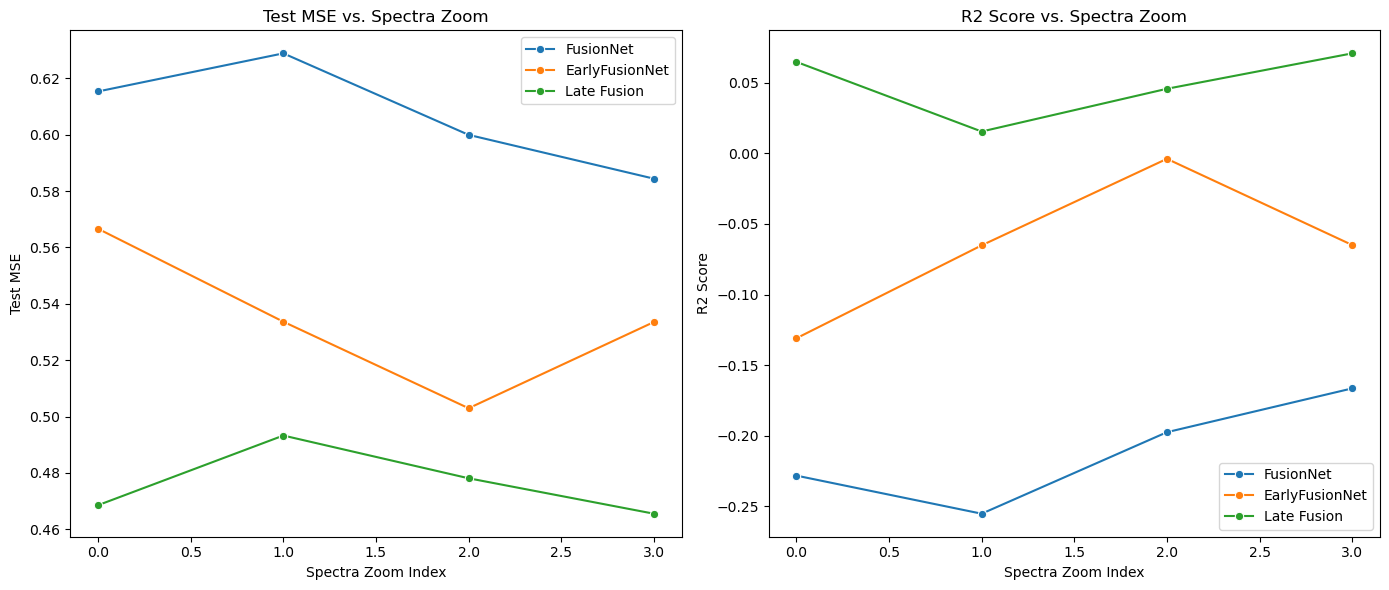

In [19]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
sns.lineplot(x=spectra_indices, y=fusion_mse_vals, marker="o", label="FusionNet")
sns.lineplot(x=spectra_indices, y=early_mse_vals, marker="o", label="EarlyFusionNet")
sns.lineplot(x=spectra_indices, y=late_mse_vals, marker="o", label="Late Fusion")
plt.xlabel("Spectra Zoom Index")
plt.ylabel("Test MSE")
plt.title("Test MSE vs. Spectra Zoom")
plt.legend()

plt.subplot(1,2,2)
sns.lineplot(x=spectra_indices, y=fusion_r2_vals, marker="o", label="FusionNet")
sns.lineplot(x=spectra_indices, y=early_r2_vals, marker="o", label="EarlyFusionNet")
sns.lineplot(x=spectra_indices, y=late_r2_vals, marker="o", label="Late Fusion")
plt.xlabel("Spectra Zoom Index")
plt.ylabel("R2 Score")
plt.title("R2 Score vs. Spectra Zoom")
plt.legend()

plt.tight_layout()
plt.show()

In [20]:
# Scatter plots for predictions (for the best spectra zoom for each architecture)
# Here we choose the spectra zoom index that yielded the lowest Test MSE for each architecture.
best_fusion_zoom = min(results_fusion, key=lambda z: results_fusion[z]['Test MSE'])
best_early_zoom = min(results_early, key=lambda z: results_early[z]['Test MSE'])
best_late_zoom = min(results_late, key=lambda z: results_late[z]['Test MSE'])

print(f"Best FusionNet spectra zoom: {best_fusion_zoom}")
print(f"Best EarlyFusionNet spectra zoom: {best_early_zoom}")
print(f"Best Late Fusion spectra zoom: {best_late_zoom}")


Best FusionNet spectra zoom: 3
Best EarlyFusionNet spectra zoom: 2
Best Late Fusion spectra zoom: 3
